In [1]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    DefaultDataCollator,
    keras_callbacks,
)
import tensorflow as tf
from huggingface_hub import notebook_login
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, extractive_qa_utils
from question_answering.paths import extractive_qa_paths

In [2]:
df_train, df_val, df_test = core_qa_utils.load_train_val_test_datasets(
    extractive_qa_paths.squad_dataset_dir
)

train_dataset, val_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_val, df_test]
)

In [3]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [4]:
def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["question"].strip()
    context = sample["context"].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)


tokenized_train_dataset = train_dataset.map(tokenize_sample)
tokenized_val_dataset = val_dataset.map(tokenize_sample)
tokenized_test_dataset = test_dataset.map(tokenize_sample)

print(
    "Max number of tokens in tokenized train dataset: ",
    len(max(tokenized_train_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized val dataset: ",
    len(max(tokenized_val_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized test dataset: ",
    len(max(tokenized_test_dataset["input_ids"], key=len)),
)

Map:   0%|          | 0/68716 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/14724 [00:00<?, ? examples/s]

Map:   0%|          | 0/14725 [00:00<?, ? examples/s]

Max number of tokens in tokenized train dataset:  870
Max number of tokens in tokenized val dataset:  866
Max number of tokens in tokenized test dataset:  817


In [5]:
max_length = 384


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_val_dataset = filter_samples_below_number_of_tokens(
    val_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x000001DA1D8DBDF0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print("Number of samples in tokenized val dataset before filtering: ", len(val_dataset))
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized val dataset after filtering: ",
    len(filtered_val_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  68716
Number of samples in tokenized val dataset before filtering:  14724
Number of samples in tokenized test dataset before filtering:  14725

---------------

Number of samples in tokenized train dataset after filtering:  67964
Number of samples in tokenized val dataset after filtering:  14573
Number of samples in tokenized test dataset after filtering:  14552


In [7]:
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["question"]]
    contexts = [c.strip() for c in dataset["context"]]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        padding="max_length",
        return_offsets_mapping=True,
    )

    offset_mapping = inputs.pop("offset_mapping")

    answer_start_indices = dataset["answer_start"]
    answer_texts = dataset["answer_text"]
    start_positions = []
    end_positions = []

    for index, offset in enumerate(offset_mapping):
        start_char = answer_start_indices[index]
        end_char = start_char + len(answer_texts[index])
        sequence_ids = inputs.sequence_ids(index)

        # Find the start and end token indices of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [8]:
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_train_dataset.column_names,
)
tokenized_val_dataset = filtered_val_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_val_dataset.column_names,
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_test_dataset.column_names,
)

Map:   0%|          | 0/67964 [00:00<?, ? examples/s]

Map:   0%|          | 0/14573 [00:00<?, ? examples/s]

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [9]:
print(
    f"All tokenized train dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_train_dataset["input_ids"]
        ]
    ),
)
print(
    f"All tokenized val dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_val_dataset["input_ids"]
        ]
    ),
)
print(
    f"All tokenized test dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_test_dataset["input_ids"]
        ]
    ),
)

All tokenized train dataset entries have 384 tokens:  True
All tokenized val dataset entries have 384 tokens:  True
All tokenized test dataset entries have 384 tokens:  True


In [10]:
# Model parameters
training_number = 1

model_name = "squad-bert-uncased"
full_model_name = f"{model_name}-{training_number}"

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
    extractive_qa_paths.training_checkpoints_dir
    / full_model_name
    / checkpoint_filename_template
)

# Hub
hub_path = extractive_qa_paths.hub_models_location / full_model_name

# Saved models
saved_models_path = extractive_qa_paths.saved_models_dir / full_model_name

# Figures
figures_dir = extractive_qa_paths.figures_dir / full_model_name

# Hyperparameters
batch_size = 8
train_epochs = 10

In [11]:
# Load model for fine-tuning
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Dataset preparation
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_train_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

tf_val_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_val_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

tf_test_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

In [13]:
# Login to hugging face hub in order to store the model there
# notebook_login()

In [14]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=1)
# push_to_hub = keras_callbacks.PushToHubCallback(
#     output_dir=full_model_name, tokenizer=tokenizer
# )

callbacks = [
    checkpoint_cb, 
    early_stop_cb, 
    # push_to_hub
]

In [15]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=2e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [16]:
model.summary()

Model: "tf_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 108,893,186
Trainable params: 108,893,186
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/10
8496/8496 [==============================] - ETA: 0s - loss: 2.6096 - end_logits_loss: 1.2598 - start_logits_loss: 1.3498 - end_logits_accuracy: 0.6570 - start_logits_accuracy: 0.6163
Epoch 1: saving model to e:\STUDIA\IPS\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-1\cp-01.ckpt
8496/8496 [==============================] - 2098s 245ms/step - loss: 2.6096 - end_logits_loss: 1.2598 - start_logits_loss: 1.3498 - end_logits_accuracy: 0.6570 - start_logits_accuracy: 0.6163 - val_loss: 1.9858 - val_end_logits_loss: 0.9554 - val_start_logits_loss: 1.0304 - val_end_logits_accuracy: 0.7340 - val_start_logits_accuracy: 0.7016
Epoch 2/10
8496/8496 [==============================] - ETA: 0s - loss: 1.5540 - end_logits_loss: 0.7389 - start_logits_loss: 0.8151 - end_logits_accuracy: 0.7780 - start_logits_accuracy: 0.7425
Epoch 2: saving model to e:\STUDIA\IPS\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-1\cp-02.ckpt
8496/8496 [=====

In [18]:
# Get best version of the model
best_model = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, remove_checkpoints=False
)

In [19]:
# Save best model's weights
extractive_qa_utils.save_model(best_model, model_name=full_model_name)

In [20]:
# Load best model
loaded_best_model = extractive_qa_utils.load_weights_into_model(
    best_model, model_name=full_model_name
)

In [21]:
# Get predictions from best_model
best_model_preds = best_model.evaluate(tf_test_dataset)

1819/1819 [==============================] - 262s 144ms/step - loss: 2.0131 - end_logits_loss: 0.9623 - start_logits_loss: 1.0508 - end_logits_accuracy: 0.7308 - start_logits_accuracy: 0.6905


In [22]:
loaded_best_model_preds = loaded_best_model.evaluate(tf_test_dataset)

1819/1819 [==============================] - 262s 144ms/step - loss: 2.0131 - end_logits_loss: 0.9623 - start_logits_loss: 1.0508 - end_logits_accuracy: 0.7308 - start_logits_accuracy: 0.6905


In [23]:
best_model_preds

[2.0130584239959717,
 0.9622660279273987,
 1.0507932901382446,
 0.7307586669921875,
 0.6904892921447754]

In [24]:
loaded_best_model_preds

[2.013058662414551,
 0.9622660279273987,
 1.0507932901382446,
 0.7307586669921875,
 0.6904892921447754]

In [17]:
loaded_model = extractive_qa_utils.load_model(model_checkpoint=model_checkpoint, model_name=full_model_name)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
loaded_model_preds = loaded_model.predict(tf_test_dataset)

NameError: name 'loaded_model' is not defined

In [19]:
loaded_model_preds

TFQuestionAnsweringModelOutput(loss=None, start_logits=array([[-6.855, -4.04 , -6.355, ..., -7.93 , -7.957, -7.984],
       [-7.074, -5.15 , -6.82 , ..., -7.934, -7.95 , -7.95 ],
       [-6.984, -4.03 , -5.293, ..., -7.81 , -7.805, -7.74 ],
       ...,
       [-5.895, -5.18 , -6.   , ..., -7.96 , -8.01 , -8.01 ],
       [-7.227, -5.824, -7.12 , ..., -7.77 , -7.766, -7.74 ],
       [-6.812, -5.73 , -6.984, ..., -7.84 , -7.816, -7.816]],
      dtype=float16), end_logits=array([[-5.367, -5.79 , -7.24 , ..., -8.16 , -8.14 , -8.12 ],
       [-5.6  , -5.254, -6.83 , ..., -8.15 , -8.11 , -8.12 ],
       [-6.37 , -4.715, -7.758, ..., -8.24 , -8.25 , -8.29 ],
       ...,
       [-3.973, -6.137, -5.758, ..., -8.086, -8.016, -8.02 ],
       [-6.01 , -5.715, -7.746, ..., -8.32 , -8.31 , -8.336],
       [-6.688, -6.46 , -7.145, ..., -8.11 , -8.11 , -8.13 ]],
      dtype=float16), hidden_states=None, attentions=None)

In [21]:
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [23]:
loaded_model_evaluation = loaded_model.evaluate(tf_test_dataset)

1819/1819 [==============================] - 99s 54ms/step - loss: 2.0131 - end_logits_loss: 0.9623 - start_logits_loss: 1.0508 - end_logits_accuracy: 0.7309 - start_logits_accuracy: 0.6906


In [24]:
loaded_model_evaluation

[2.0131354331970215,
 0.9623449444770813,
 1.050808310508728,
 0.7308961153030396,
 0.6906267404556274]

In [22]:
history.history

{'loss': [2.609588146209717, 1.5540210008621216],
 'end_logits_loss': [1.2598363161087036, 0.738911509513855],
 'start_logits_loss': [1.3497529029846191, 0.8151091933250427],
 'end_logits_accuracy': [0.6570096015930176, 0.7779706716537476],
 'start_logits_accuracy': [0.6163115501403809, 0.742540180683136],
 'val_loss': [1.985767126083374, 2.083064317703247],
 'val_end_logits_loss': [0.9554057717323303, 0.9962221384048462],
 'val_start_logits_loss': [1.0303596258163452, 1.0868394374847412],
 'val_end_logits_accuracy': [0.734028697013855, 0.7425375580787659],
 'val_start_logits_accuracy': [0.7016400098800659, 0.70328688621521]}

In [26]:
figures_dir

WindowsPath('e:/STUDIA/IPS/question-answering/extractive-qa/figures/squad-bert-uncased-1')

In [33]:
from pathlib import Path
import matplotlib.pyplot as plt
import os

def _create_dirs_if_not_exists(directory: Path):
    if not directory.is_dir():
        directory.mkdir()

def plot_and_save_fig_from_history(
    history,
    attributes,
    title,
    y_label,
    x_label,
    legend_descriptors,
    figure_dir_path,
    figure_filename,
):
    for attribute in attributes:
        plt.plot(history.history[attribute])
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(legend_descriptors, loc="upper left")

    figure_dir = os.path.join(os.curdir, figure_dir_path)
    _create_dirs_if_not_exists(figure_dir_path)

    plt.savefig(os.path.join(figure_dir, figure_filename))
    plt.show()

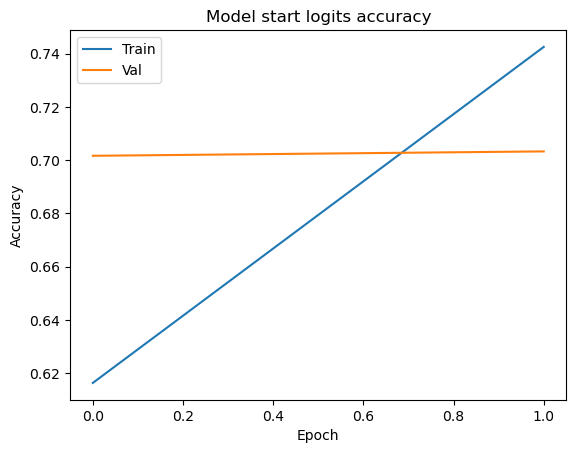

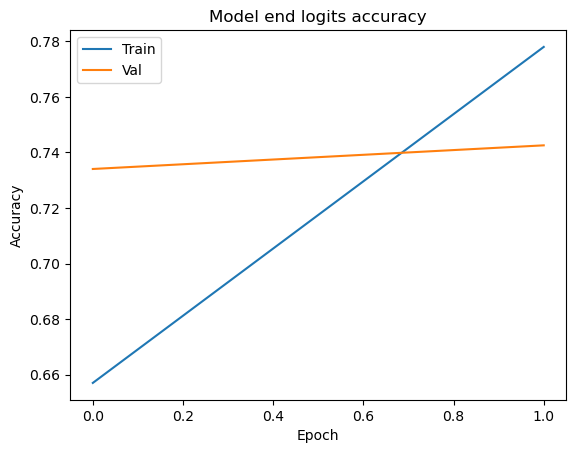

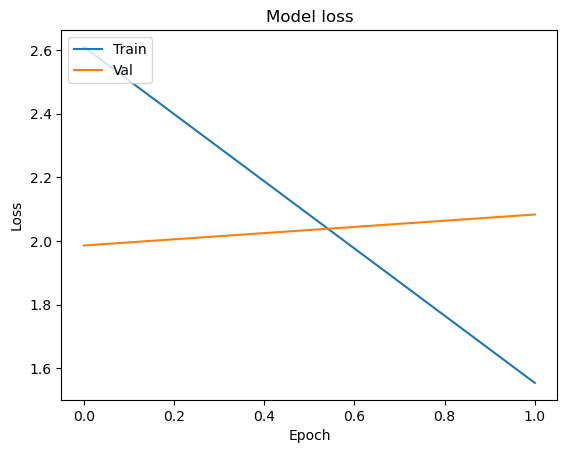

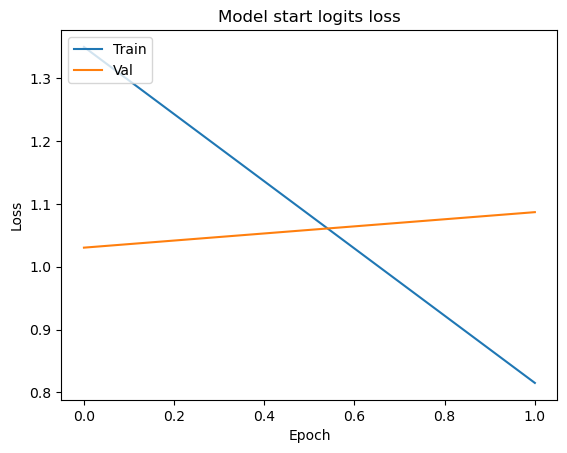

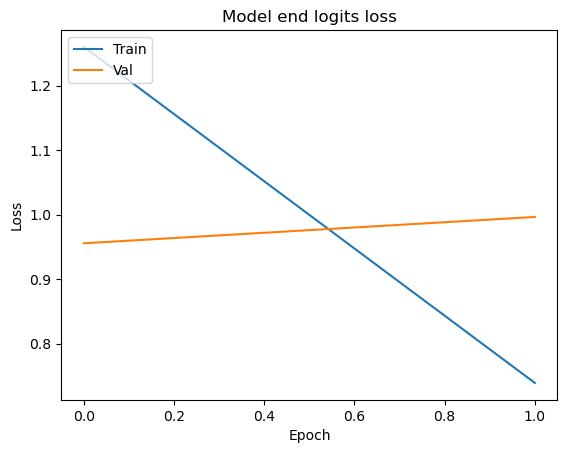

In [36]:
plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_accuracy", "val_start_logits_accuracy"],
    title="Model start logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_accuracy.png",
)

plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_accuracy", "val_end_logits_accuracy"],
    title="Model end logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_accuracy.png",
)

plot_and_save_fig_from_history(
    history,
    attributes=["loss", "val_loss"],
    title="Model loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_loss.png",
)

plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_loss", "val_start_logits_loss"],
    title="Model start logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_loss.png",
)

plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_loss", "val_end_logits_loss"],
    title="Model end logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_loss.png",
)

In [65]:
import sklearn.metrics as skmetrics

def get_classification_evaluation_metrics(class_actual, class_preds, average='binary'):
    precision = skmetrics.precision_score(class_actual, class_preds, average=average)
    recall = skmetrics.recall_score(class_actual, class_preds, average=average)
    f1 = skmetrics.f1_score(class_actual, class_preds, average=average)
    return precision, recall, f1

In [40]:
model_preds = best_model.predict(tf_test_dataset)

1819/1819 [==============================] - 151s 82ms/step


In [47]:
import numpy as np

def get_class_preds(predictions, type='start_logits', return_classes=True, model_returns_logits=True):
    predictions = predictions[type]
    probabilities = tf.nn.softmax(predictions)
    if return_classes:
        return np.argmax(probabilities, axis=1)
    else:
        return probabilities.numpy()

In [66]:
start_preds = get_class_preds(predictions=model_preds, type='start_logits')
end_preds = get_class_preds(predictions=model_preds, type='end_logits')

In [67]:
tokenized_test_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 14552
})

In [68]:
start_precision, start_recall, start_f1 = get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['start_positions'],
    class_preds=start_preds,
    average='micro'
)

print(f"Precision score: ", start_precision)
print(f"Recall score: ", start_recall)
print(f"F1 score: ", start_f1)

Precision score:  0.6921385376580539
Recall score:  0.6921385376580539
F1 score:  0.6921385376580539


In [69]:
end_precision, end_recall, end_f1 = get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['end_positions'],
    class_preds=end_preds,
    average='micro'
)

print(f"Precision score: ", end_precision)
print(f"Recall score: ", end_recall)
print(f"F1 score: ", end_f1)

Precision score:  0.7335074216602528
Recall score:  0.7335074216602528
F1 score:  0.7335074216602528


In [57]:
from evaluate import load

exact_match_metric = load("exact_match")

In [71]:
len(start_preds)

14552

In [72]:
len(end_preds)

14552

In [77]:
filtered_test_dataset[0]

{'index': 0,
 'id': '5733a8ffd058e614000b5f9f',
 'context': "Despite the calamity and huge death toll, Lisbon suffered no epidemics and within less than one year was already being rebuilt. The new city centre of Lisbon was designed to resist subsequent earthquakes. Architectural models were built for tests, and the effects of an earthquake were simulated by marching troops around the models. The buildings and big squares of the Pombaline City Centre still remain as one of Lisbon's tourist attractions. Sebastião de Melo also made an important contribution to the study of seismology by designing an inquiry that was sent to every parish in the country.",
 'question': 'Did Lisbon suffer any epidemics from the calamity?',
 'answer_text': 'Lisbon suffered no epidemics',
 'answer_start': 42}

In [82]:
tokenized_test_dataset[0]

{'input_ids': [101,
  2106,
  11929,
  9015,
  2151,
  16311,
  2015,
  2013,
  1996,
  10250,
  10631,
  3723,
  1029,
  102,
  2750,
  1996,
  10250,
  10631,
  3723,
  1998,
  4121,
  2331,
  9565,
  1010,
  11929,
  4265,
  2053,
  16311,
  2015,
  1998,
  2306,
  2625,
  2084,
  2028,
  2095,
  2001,
  2525,
  2108,
  7183,
  1012,
  1996,
  2047,
  2103,
  2803,
  1997,
  11929,
  2001,
  2881,
  2000,
  9507,
  4745,
  17932,
  1012,
  6549,
  4275,
  2020,
  2328,
  2005,
  5852,
  1010,
  1998,
  1996,
  3896,
  1997,
  2019,
  8372,
  2020,
  23599,
  2011,
  10998,
  3629,
  2105,
  1996,
  4275,
  1012,
  1996,
  3121,
  1998,
  2502,
  14320,
  1997,
  1996,
  13433,
  11201,
  4179,
  2103,
  2803,
  2145,
  3961,
  2004,
  2028,
  1997,
  11929,
  1005,
  1055,
  7538,
  13051,
  1012,
  7367,
  22083,
  10711,
  2080,
  2139,
  11463,
  2080,
  2036,
  2081,
  2019,
  2590,
  6691,
  2000,
  1996,
  2817,
  1997,
  7367,
  2964,
  6779,
  2011,
  12697,
  2019,
  9934,


In [81]:
tokenizer.decode(tokenized_test_dataset[0]['input_ids'])

"[CLS] did lisbon suffer any epidemics from the calamity? [SEP] despite the calamity and huge death toll, lisbon suffered no epidemics and within less than one year was already being rebuilt. the new city centre of lisbon was designed to resist subsequent earthquakes. architectural models were built for tests, and the effects of an earthquake were simulated by marching troops around the models. the buildings and big squares of the pombaline city centre still remain as one of lisbon's tourist attractions. sebastiao de melo also made an important contribution to the study of seismology by designing an inquiry that was sent to every parish in the country. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [86]:
tokenizer.decode(tokenized_test_dataset[0]['input_ids'][24:28])

'lisbon suffered no epidemic'

In [88]:
filtered_test_dataset['answer_text']

['Lisbon suffered no epidemics',
 'Hispanic',
 "Beijing was captured by Li Zicheng's peasant rebels",
 'Tate Britain',
 'thirteen',
 'Ariel Sharon',
 'Operation Serval',
 '$45 million',
 'Constantinople',
 'water',
 'crimson and royal blue',
 '70,500',
 'in 1876',
 'Tracy Hall',
 'King Evander',
 'U.S. and South Sudan',
 'early 1980s',
 'mixed polarization',
 'New York City',
 'Dionysus',
 'Oktoberfest of Blumenau',
 'during the Belle Époque',
 'in fonts',
 'October 31, 1916',
 'the Napoleonic Code',
 'At over 5 million, Puerto Ricans are easily the 2nd largest Hispanic group. Of all major Hispanic groups',
 'three',
 'Khagan',
 '$100 "perpetual scholarships"',
 'medieval Muslim world',
 'early 19th century',
 'Premier League',
 '1967',
 'Georgia',
 'attend anti-union meetings',
 "the group's underlying set",
 'Santo Domingo',
 'New Russia',
 'steam turbines',
 '10th century',
 'spiritual',
 'feed aggregator',
 'resin',
 '"always crescendo to a high note"',
 'Ögedei Khan',
 'saloon',
 

In [90]:
decoded_model_answer_texts = tokenized_test_dataset['input_ids'].map(
    tokenizer.decode,
    batched=True,
)

AttributeError: 'list' object has no attribute 'map'

In [92]:
type(tokenized_test_dataset)

datasets.arrow_dataset.Dataset

In [96]:
def decode_input_ids(input_ids_list):
    return tokenizer.decode(input_ids_list['input_ids'])

In [98]:
filtered_train_dataset

Dataset({
    features: ['index', 'id', 'context', 'question', 'answer_text', 'answer_start'],
    num_rows: 67964
})

In [103]:
tokenizer.decode(tokenized_test_dataset[0]['input_ids'])

"[CLS] did lisbon suffer any epidemics from the calamity? [SEP] despite the calamity and huge death toll, lisbon suffered no epidemics and within less than one year was already being rebuilt. the new city centre of lisbon was designed to resist subsequent earthquakes. architectural models were built for tests, and the effects of an earthquake were simulated by marching troops around the models. the buildings and big squares of the pombaline city centre still remain as one of lisbon's tourist attractions. sebastiao de melo also made an important contribution to the study of seismology by designing an inquiry that was sent to every parish in the country. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [104]:
tokenized_test_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 14552
})

In [106]:
tokenized_test_dataset[0]['end_positions']

28

In [128]:
def extract_answer_tokens(tokenized_dataset_row):
    start = tokenized_dataset_row['start_positions']
    end = tokenized_dataset_row['end_positions']
    tokenized_dataset_row['answer_tokens'] = tokenized_dataset_row['input_ids'][start:end]
    return tokenized_dataset_row

In [129]:
model_answer_tokens = tokenized_test_dataset.map(extract_answer_tokens)

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [118]:
model_answer_tokens = tokenized_test_dataset.map(lambda row: {"answer_tokens": extract_answer_tokens(row)})

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [121]:
tokenized_test_dataset[0]['start_positions']

24

In [126]:
tokenized_test_dataset[0]['input_ids'][24:28]

[11929, 4265, 2053, 16311]

In [ ]:
extract_answer_tokens(tokenized_test_dataset[0])

In [135]:
type(model_answer_tokens[0]['answer_tokens'][0])

int

In [132]:
def decode_answer_tokens(tokenized_dataset_row):
    tokens = tokenized_dataset_row['answer_tokens']
    answer = tokenizer.decode(tokens)
    return answer

In [138]:
tokenized_test_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 14552
})

In [144]:
answers = model_answer_tokens.map(lambda row: {"answer": decode_answer_tokens(row)}, remove_columns=model_answer_tokens.column_names)
#     decode_answer_tokens,
#     batched=True,
#     remove_columns=model_answer_tokens.column_names,
# )

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [147]:
answers

Dataset({
    features: ['answer'],
    num_rows: 14552
})

In [149]:
filtered_test_dataset

Dataset({
    features: ['index', 'id', 'context', 'question', 'answer_text', 'answer_start'],
    num_rows: 14552
})

In [154]:
a = filtered_test_dataset[0:1]
b = answers[0:1]
a,b

({'index': [0],
  'id': ['5733a8ffd058e614000b5f9f'],
  'context': ["Despite the calamity and huge death toll, Lisbon suffered no epidemics and within less than one year was already being rebuilt. The new city centre of Lisbon was designed to resist subsequent earthquakes. Architectural models were built for tests, and the effects of an earthquake were simulated by marching troops around the models. The buildings and big squares of the Pombaline City Centre still remain as one of Lisbon's tourist attractions. Sebastião de Melo also made an important contribution to the study of seismology by designing an inquiry that was sent to every parish in the country."],
  'question': ['Did Lisbon suffer any epidemics from the calamity?'],
  'answer_text': ['Lisbon suffered no epidemics'],
  'answer_start': [42]},
 {'answer': ['lisbon suffered no epidemic']})

In [151]:
results = exact_match_metric.compute(predictions=filtered_test_dataset['answer_text'], references=answers['answer'])
results

{'exact_match': 0.0005497526113249038}

In [155]:
results = exact_match_metric.compute(predictions=a['answer_text'], references=b['answer'])
results

{'exact_match': 0.0}

In [156]:
squad = load("squad")

In [157]:
results = squad.compute(predictions=a['answer_text'], references=b['answer'])

ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}},
Input predictions: ['Lisbon suffered no epidemics'],
Input references: ['lisbon suffered no epidemic']